# Librerie 

In [1]:
#Base
import os
import pandas as pd
import numpy as np
import scipy as sp
import time
import sys
import matplotlib as plt
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.metrics import (
    accuracy_score,      
    precision_score,     
    recall_score,        
    confusion_matrix,       
    f1_score             
)


sys.path.insert(1,'../Data') 
from preprocessing_v3 import preprocessing_diabetes_v3,combination_features

#Set the random seed for reproducibility
import random
random.seed(42)
np.random.seed(42) 




# Funzioni

In [2]:
from sklearn import metrics


def knn_grid_search(X_train_in, y_train_in, max_neighbors=5, num_partizioni=5):
    KNN = KNeighborsClassifier() 
    #Grid space

    search_space = {
    'n_neighbors': list(range(1, max_neighbors + 1)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

    #Grid search with cross-validation
    grid_search = GridSearchCV(
    KNN,
    param_grid = search_space,
    scoring = { "accuracy": "accuracy",
                "precision": "precision",
                "recall": "recall",
                "f1": "f1" },
        refit='f1',
    cv= num_partizioni,
    )
    
    grid_search.fit(X_train_in, y_train_in)
    
   
    best_index = grid_search.best_index_

    mean_accuracy = grid_search.cv_results_['mean_test_accuracy'][best_index]
    mean_precision = grid_search.cv_results_['mean_test_precision'][best_index]
    mean_recall = grid_search.cv_results_['mean_test_recall'][best_index]
    mean_f1 = grid_search.cv_results_['mean_test_f1'][best_index]


    cv_metrics_best_model_df = pd.DataFrame(
        [[mean_accuracy, mean_precision, mean_recall, mean_f1]],
        columns=['Accuracy', 'Precision', 'Recall', 'f1'],
        index=['Performance Train']
    )

    KNN_Best= grid_search.best_estimator_    
    Parameter_Best = grid_search.best_params_    

    
    return KNN_Best, Parameter_Best , cv_metrics_best_model_df


def evaluate_knn(knn_model, X_test, y_test, label='test'):
    start=time.time()
    y_pred = knn_model.predict(X_test)
    end=time.time()
    TempoEsecuzione = end - start
    accuracy = accuracy_score(y_test, y_pred)      
    precision = precision_score(y_test, y_pred)     
    recall = recall_score(y_test, y_pred)           
    f1 = f1_score(y_test, y_pred)                   


    metrics_df = pd.DataFrame(
    data=[[accuracy, precision, recall, f1, TempoEsecuzione]],   
    columns=['Accuracy', 'Precision', 'Recall', 'f1','Time'],  
    index=[label]                               
    )

    conf_mat=confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(conf_mat,
                        index=['Reali sani', 'Reali diabetici'],
                        columns=['Predetti sani', 'Predetti diabetici']

            )
    return metrics_df, cm_df, 




# Importazione dati

In [3]:
train_data= pd.read_csv('../Data/diabetes_train.csv')
test_data= pd.read_csv('../Data/diabetes_test.csv')

# Modelli con diversi PREPROCESSING 

### oversample=false augment=false 


In [4]:
#Normal 
X_train_norm, X_test_norm, y_train_norm, y_test_norm = preprocessing_diabetes_v3(train_data, test_data, augment=False, oversample=False, delete_smoking=False)
knn_best_norm, best_params_norm, performance_train_df_norm = knn_grid_search(X_train_norm, y_train_norm, max_neighbors=30, num_partizioni=10)
parameters_norm = pd.DataFrame([best_params_norm], index=["PARAMETERS BEST KNN"])
metrics_df_norm, conf_mat_norm = evaluate_knn(knn_best_norm, X_test_norm, y_test_norm, label='Performaramce Test')

# PCA
X_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = preprocessing_diabetes_v3(train_data, test_data, option='PCA', augment=False, oversample=False, delete_smoking=False)
knn_best_PCA, best_params_PCA, performance_train_df_PCA = knn_grid_search(X_train_PCA, y_train_PCA, max_neighbors=30, num_partizioni=10)
parameters_PCA = pd.DataFrame([best_params_PCA], index=["PARAMETERS BEST KNN"])
metrics_df_PCA, conf_mat_PCA = evaluate_knn(knn_best_PCA, X_test_PCA, y_test_PCA, label='Performance Test')

#No Correlation
X_train_noCorr, X_test_noCorr, y_train_noCorr, y_test_noCorr = preprocessing_diabetes_v3(train_data, test_data, option='Delete', augment=False, oversample=False, delete_smoking=False)
knn_best_noCorr, best_params_noCorr, performance_train_df_noCorr = knn_grid_search(X_train_noCorr, y_train_noCorr, max_neighbors=30, num_partizioni=10)
parameters_noCorr = pd.DataFrame([best_params_noCorr], index=["PARAMETERS BEST KNN"])
metrics_df_noCorr, conf_mat_noCorr = evaluate_knn(knn_best_noCorr, X_test_noCorr, y_test_noCorr, label='Performance Test')

#No Smoking
X_train_NoSmok, X_test_NoSmok, y_train_NoSmok, y_test_NoSmok = preprocessing_diabetes_v3(train_data, test_data, augment=False, oversample=False, delete_smoking=True)
knn_best_NoSmok, best_params_NoSmok, performance_train_df_NoSmok = knn_grid_search(X_train_NoSmok, y_train_NoSmok, max_neighbors=30, num_partizioni=10)
parameters_NoSmok = pd.DataFrame([best_params_NoSmok], index=["PARAMETERS BEST KNN"])
metrics_df_NoSmok, conf_mat_NoSmok = evaluate_knn(knn_best_NoSmok, X_test_NoSmok, y_test_NoSmok, label='Performance Test')



### oversample=True augment=True

In [5]:
#Normal
X_train_norm2, X_test_norm2, y_train_norm2, y_test_norm2 = preprocessing_diabetes_v3(train_data, test_data, augment=True, oversample=True, delete_smoking=False)
knn_best_norm2, best_params_norm2, performance_train_df_norm2 = knn_grid_search(X_train_norm2, y_train_norm2, max_neighbors=30, num_partizioni=10)
parameters_norm2 = pd.DataFrame([best_params_norm2], index=["PARAMETERS BEST KNN"])
metrics_df_norm2, conf_mat_norm2 = evaluate_knn(knn_best_norm2, X_test_norm2, y_test_norm2, label='Performaramce Test')

# PCA
X_train_PCA2, X_test_PCA2, y_train_PCA2, y_test_PCA2 = preprocessing_diabetes_v3(train_data, test_data, option='PCA',augment=True, oversample=True, delete_smoking=False)
knn_best_PCA2, best_params_PCA2, performance_train_df_PCA2 = knn_grid_search(X_train_PCA2, y_train_PCA2, max_neighbors=30, num_partizioni=10)
parameters_PCA2 = pd.DataFrame([best_params_PCA2], index=["PARAMETERS BEST KNN"])
metrics_df_PCA2, conf_mat_PCA2 = evaluate_knn(knn_best_PCA2, X_test_PCA2, y_test_PCA2, label='Performance Test')

#No Correlation
X_train_noCorr2, X_test_noCorr2, y_train_noCorr2, y_test_noCorr2 = preprocessing_diabetes_v3(train_data, test_data, option='Delete',augment=True, oversample=True, delete_smoking=False)
knn_best_noCorr2, best_params_noCorr2, performance_train_df_noCorr2 = knn_grid_search(X_train_noCorr2, y_train_noCorr2, max_neighbors=30, num_partizioni=10)
parameters_noCorr2 = pd.DataFrame([best_params_noCorr2], index=["PARAMETERS BEST KNN"])
metrics_df_noCorr2, conf_mat_noCorr2 = evaluate_knn(knn_best_noCorr2, X_test_noCorr2, y_test_noCorr2, label='Performance Test')

#No Smoking
X_train_NoSmok2, X_test_NoSmok2, y_train_NoSmok2, y_test_NoSmok2 = preprocessing_diabetes_v3(train_data, test_data, augment=True, oversample=True, delete_smoking=True)
knn_best_NoSmok2, best_params_NoSmok2, performance_train_df_NoSmok2 = knn_grid_search(X_train_NoSmok2, y_train_NoSmok2, max_neighbors=30, num_partizioni=10)
parameters_NoSmok2 = pd.DataFrame([best_params_NoSmok2], index=["PARAMETERS BEST KNN"])
metrics_df_NoSmok2, conf_mat_NoSmok2 = evaluate_knn(knn_best_NoSmok2, X_test_NoSmok2, y_test_NoSmok2, label='Performance Test')

 

### oversample=True augment=False 

In [6]:
#Normal
X_train_norm3, X_test_norm3, y_train_norm3, y_test_norm3 = preprocessing_diabetes_v3(train_data, test_data, augment=False, oversample=True, delete_smoking=False) 
knn_best_norm3, best_params_norm3, performance_train_df_norm3 = knn_grid_search(X_train_norm3, y_train_norm3, max_neighbors=30, num_partizioni=10)
parameters_norm3 = pd.DataFrame([best_params_norm3], index=["PARAMETERS BEST KNN"])
metrics_df_norm3, conf_mat_norm3 = evaluate_knn(knn_best_norm3, X_test_norm3, y_test_norm3, label='Performaramce Test')

# PCA
X_train_PCA3, X_test_PCA3, y_train_PCA3, y_test_PCA3 = preprocessing_diabetes_v3(train_data, test_data, option='PCA',augment=False, oversample=True, delete_smoking=False)
knn_best_PCA3, best_params_PCA3, performance_train_df_PCA3 = knn_grid_search(X_train_PCA3, y_train_PCA3, max_neighbors=30, num_partizioni=10)
parameters_PCA3 = pd.DataFrame([best_params_PCA3], index=["PARAMETERS BEST KNN"])
metrics_df_PCA3, conf_mat_PCA3 = evaluate_knn(knn_best_PCA3, X_test_PCA3, y_test_PCA3, label='Performance Test')

#No Correlation
X_train_noCorr3, X_test_noCorr3, y_train_noCorr3, y_test_noCorr3 = preprocessing_diabetes_v3(train_data, test_data, option='Delete',augment=False, oversample=True, delete_smoking=False)
knn_best_noCorr3, best_params_noCorr3, performance_train_df_noCorr3 = knn_grid_search(X_train_noCorr3, y_train_noCorr3, max_neighbors=30, num_partizioni=10)
parameters_noCorr3 = pd.DataFrame([best_params_noCorr3], index=["PARAMETERS BEST KNN"])
metrics_df_noCorr3, conf_mat_noCorr3 = evaluate_knn(knn_best_noCorr3, X_test_noCorr3, y_test_noCorr3, label='Performance Test')

#No Smoking
X_train_NoSmok3, X_test_NoSmok3, y_train_NoSmok3, y_test_NoSmok3= preprocessing_diabetes_v3(train_data, test_data, augment=False, oversample=True, delete_smoking=True)
knn_best_NoSmok3, best_params_NoSmok3, performance_train_df_NoSmok3 = knn_grid_search(X_train_NoSmok3, y_train_NoSmok3, max_neighbors=30, num_partizioni=10)
parameters_NoSmok3 = pd.DataFrame([best_params_NoSmok3], index=["PARAMETERS BEST KNN"])
metrics_df_NoSmok3, conf_mat_NoSmok3 = evaluate_knn(knn_best_NoSmok3, X_test_NoSmok3, y_test_NoSmok3, label='PerformPerformance Test')


# Risultati 

OVERSAMPLE=False AUGMENT=False


,ModelName,Accuracy_Train,Precision_Train,Recall_Train,f1_Train,metric,n_neighbors,weights,Accuracy_Test,Precision_Test,Recall_Test,f1_Test,Time
0,Normal,0.969229,0.942917,0.938571,0.937319,manhattan,12,distance,0.952381,0.894737,0.918919,0.906667,0.005931
1,PCA,0.965839,0.960298,0.904286,0.927443,euclidean,2,uniform,0.931973,0.864865,0.864865,0.864865,0.011651
2,No Correlation,0.965809,0.922183,0.951905,0.932943,manhattan,5,distance,0.952381,0.894737,0.918919,0.906667,0.005407
3,No Smoking,0.965868,0.925833,0.945238,0.932658,manhattan,4,distance,0.945578,0.853659,0.945946,0.897436,0.004364


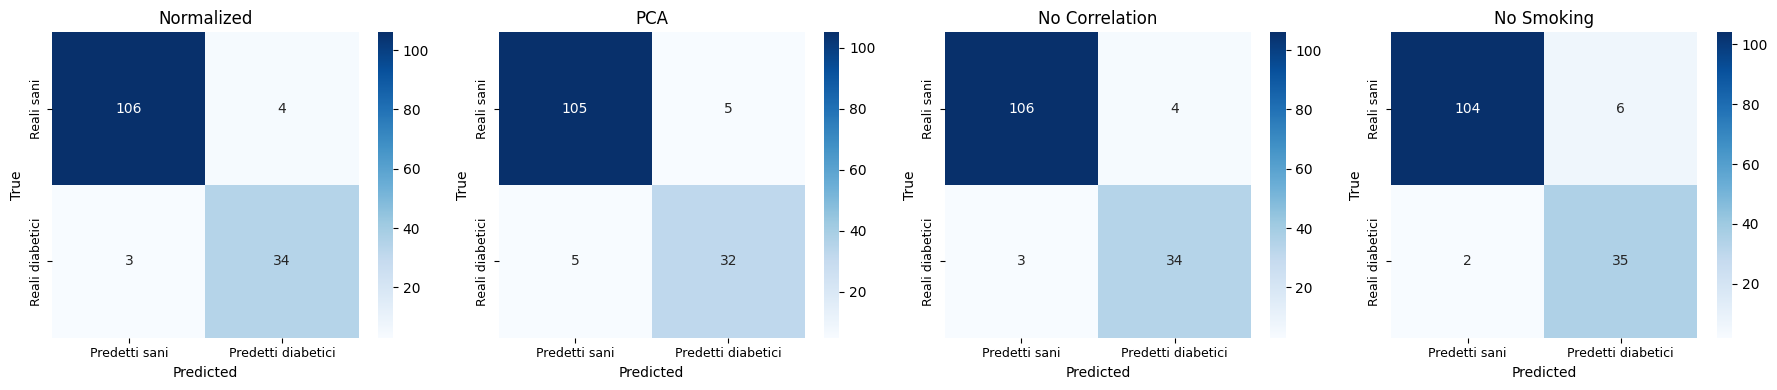

OVERSAMPLE=True AUGMENT=True


,ModelName,Accuracy_Train,Precision_Train,Recall_Train,f1_Train,metric,n_neighbors,weights,Accuracy_Test,Precision_Test,Recall_Test,f1_Test,Time
0,Normal,0.978396,0.961438,0.997727,0.979043,manhattan,1,uniform,0.959184,0.860465,1.000000,0.925000,0.024377
1,PCA,0.970441,0.955421,0.988584,0.971289,euclidean,1,uniform,0.972789,0.902439,1.000000,0.948718,0.017513
2,No Correlation,0.973851,0.956972,0.993182,0.974577,manhattan,1,uniform,0.952381,0.840909,1.000000,0.913580,0.023331
3,No Smoking,0.976123,0.969440,0.984091,0.976421,manhattan,2,uniform,0.965986,0.900000,0.972973,0.935065,0.021148


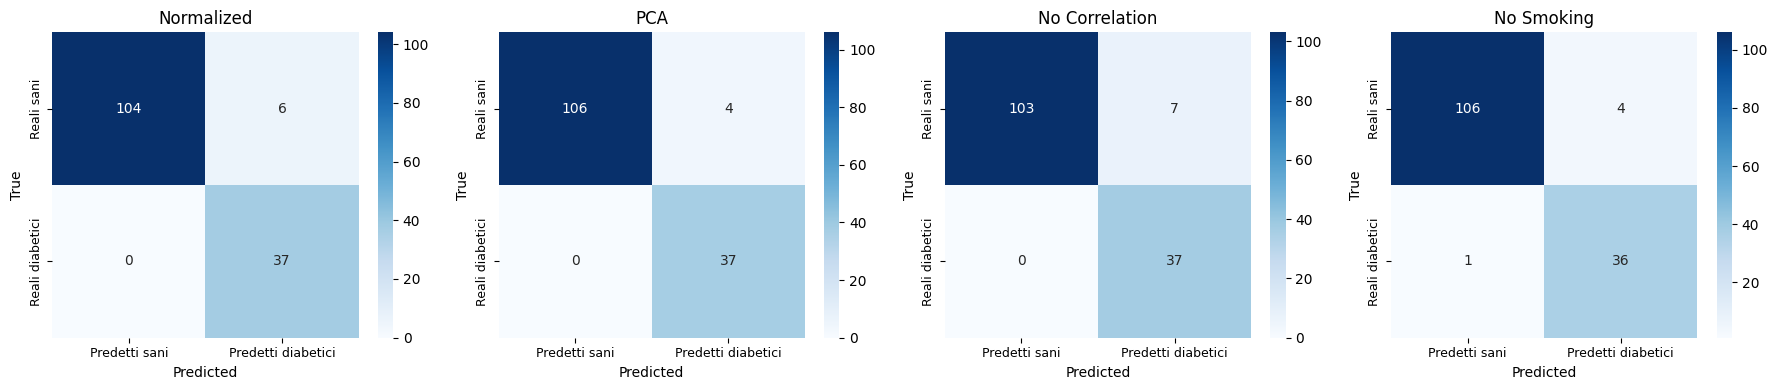

OVERSAMPLE=True AUGMENT=False


,ModelName,Accuracy_Train,Precision_Train,Recall_Train,f1_Train,metric,n_neighbors,weights,Accuracy_Test,Precision_Test,Recall_Test,f1_Test,Time
0,Normal,0.973851,0.966601,0.981818,0.974053,manhattan,2,uniform,0.952381,0.875000,0.945946,0.909091,0.014512
1,PCA,0.971539,0.950396,0.995455,0.972304,manhattan,1,uniform,0.945578,0.837209,0.972973,0.900000,0.012320
2,No Correlation,0.973838,0.962842,0.986364,0.974331,manhattan,2,uniform,0.959184,0.897436,0.945946,0.921053,0.014046
3,No Smoking,0.978383,0.971571,0.986364,0.978695,manhattan,2,uniform,0.965986,0.900000,0.972973,0.935065,0.013471


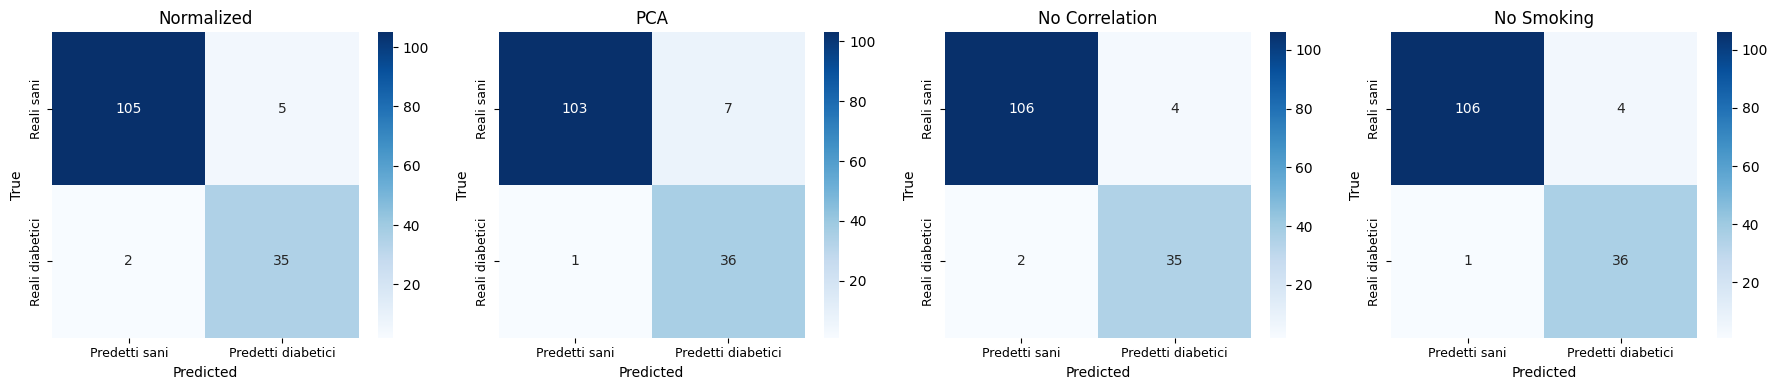

In [7]:
### === OUTPUT RESULTS === ###
#_________________________________________________________________________________________________________________________
#oversample=false augment=false
print("OVERSAMPLE=False AUGMENT=False")

#PERFORMANCE TRAINING
df_norm_test = performance_train_df_norm.reset_index(drop=True).copy()
df_norm_test['ModelName'] = 'Normal'
df_PCA_test = performance_train_df_PCA.reset_index(drop=True).copy()
df_PCA_test['ModelName'] = 'PCA'
df_noCorr_test = performance_train_df_noCorr.reset_index(drop=True).copy()
df_noCorr_test['ModelName'] = 'No Correlation'
df_NoSmok_test = performance_train_df_NoSmok.reset_index(drop=True).copy()
df_NoSmok_test['ModelName'] = 'No Smoking'

performance_train_all = pd.concat([df_norm_test, df_PCA_test, df_noCorr_test, df_NoSmok_test], ignore_index=True)
performance_train_all = performance_train_all[['ModelName', 'Accuracy', 'Precision', 'Recall', 'f1']]

#PARAMETRI MODELLO
parameters_norm_cp = parameters_norm.reset_index(drop=True).copy()
parameters_norm_cp['ModelName'] = 'Normal'
parameters_PCA_cp = parameters_PCA.reset_index(drop=True).copy()
parameters_PCA_cp['ModelName'] = 'PCA'
parameters_noCorr_cp = parameters_noCorr.reset_index(drop=True).copy()
parameters_noCorr_cp['ModelName'] = 'No Correlation'
parameters_NoSmok_cp = parameters_NoSmok.reset_index(drop=True).copy()
parameters_NoSmok_cp['ModelName'] = 'No Smoking'
 
parameters_all = pd.concat([parameters_norm_cp, parameters_PCA_cp, parameters_noCorr_cp, parameters_NoSmok_cp], ignore_index=True)
parameters_all = parameters_all[['ModelName', 'metric', 'n_neighbors', 'weights']]

df_combined = performance_train_all.merge(parameters_all, on='ModelName')

#PERFORMANCE TEST
df_norm_test = metrics_df_norm.reset_index(drop=True).copy()
df_norm_test['ModelName'] = 'Normal'
df_PCA_test = metrics_df_PCA.reset_index(drop=True).copy()
df_PCA_test['ModelName'] = 'PCA'
df_noCorr_test = metrics_df_noCorr.reset_index(drop=True).copy()
df_noCorr_test['ModelName'] = 'No Correlation'
df_NoSmok_test = metrics_df_NoSmok.reset_index(drop=True).copy()
df_NoSmok_test['ModelName'] = 'No Smoking'

performance_test_all = pd.concat([df_norm_test, df_PCA_test, df_noCorr_test, df_NoSmok_test], ignore_index=True)
performance_test_all = performance_test_all[['ModelName', 'Accuracy', 'Precision', 'Recall', 'f1','Time']]

#Display Results
performance_all=pd.merge(df_combined, performance_test_all, on="ModelName", how="inner")
performance_all = performance_all.rename(columns=lambda col: col.replace('_x', '_Train').replace('_y', '_Test'))
display(performance_all)

# MATRICE DI CONFUSIONE
fig, axes = plt.subplots(1, 4, figsize=(18, 4))
sns.heatmap(conf_mat_norm, annot=True, fmt='d', cmap='Blues', ax=axes[0], annot_kws={"size": 10})
axes[0].set_title('Normalized', fontsize=12)
axes[0].set_xlabel('Predicted', fontsize=10)
axes[0].set_ylabel('True', fontsize=10)
axes[0].tick_params(axis='both', labelsize=9)

sns.heatmap(conf_mat_PCA, annot=True, fmt='d', cmap='Blues', ax=axes[1], annot_kws={"size": 10})
axes[1].set_title('PCA', fontsize=12)
axes[1].set_xlabel('Predicted', fontsize=10)
axes[1].set_ylabel('True', fontsize=10)
axes[1].tick_params(axis='both', labelsize=9)

sns.heatmap(conf_mat_noCorr, annot=True, fmt='d', cmap='Blues', ax=axes[2], annot_kws={"size": 10})
axes[2].set_title('No Correlation', fontsize=12)
axes[2].set_xlabel('Predicted', fontsize=10)
axes[2].set_ylabel('True', fontsize=10)
axes[2].tick_params(axis='both', labelsize=9)

sns.heatmap(conf_mat_NoSmok, annot=True, fmt='d', cmap='Blues', ax=axes[3], annot_kws={"size": 10})
axes[3].set_title('No Smoking', fontsize=12)
axes[3].set_xlabel('Predicted', fontsize=10)
axes[3].set_ylabel('True', fontsize=10)
axes[3].tick_params(axis='both', labelsize=9)

plt.tight_layout()
plt.show()

#_________________________________________________________________________________________________________________________
#oversample=True augment=True

print("OVERSAMPLE=True AUGMENT=True")

#PERFORMANCE TRAINING
df_norm_test2 = performance_train_df_norm2.reset_index(drop=True).copy()
df_norm_test2['ModelName'] = 'Normal'
df_PCA_test2 = performance_train_df_PCA2.reset_index(drop=True).copy()
df_PCA_test2['ModelName'] = 'PCA'
df_noCorr_test2 = performance_train_df_noCorr2.reset_index(drop=True).copy()
df_noCorr_test2['ModelName'] = 'No Correlation'
df_NoSmok_test2 = performance_train_df_NoSmok2.reset_index(drop=True).copy()
df_NoSmok_test2['ModelName'] = 'No Smoking'

performance_train_all2 = pd.concat([df_norm_test2, df_PCA_test2, df_noCorr_test2, df_NoSmok_test2], ignore_index=True)
performance_train_all2 = performance_train_all2[['ModelName', 'Accuracy', 'Precision', 'Recall', 'f1']]

#PARAMETRI MODELLO
parameters_norm_cp2 = parameters_norm2.reset_index(drop=True).copy()
parameters_norm_cp2['ModelName'] = 'Normal'
parameters_PCA_cp2 = parameters_PCA2.reset_index(drop=True).copy()
parameters_PCA_cp2['ModelName'] = 'PCA'
parameters_noCorr_cp2 = parameters_noCorr2.reset_index(drop=True).copy()
parameters_noCorr_cp2['ModelName'] = 'No Correlation'
parameters_NoSmok_cp2 = parameters_NoSmok2.reset_index(drop=True).copy()
parameters_NoSmok_cp2['ModelName'] = 'No Smoking'

parameters_all2 = pd.concat([parameters_norm_cp2, parameters_PCA_cp2, parameters_noCorr_cp2, parameters_NoSmok_cp2], ignore_index=True)
parameters_all2 = parameters_all2[['ModelName', 'metric', 'n_neighbors', 'weights']]

df_combined2 = performance_train_all2.merge(parameters_all2, on='ModelName')

# PERFORMANCE TEST
df_norm_test2 = metrics_df_norm2.reset_index(drop=True).copy()
df_norm_test2['ModelName'] = 'Normal'
df_PCA_test2 = metrics_df_PCA2.reset_index(drop=True).copy()
df_PCA_test2['ModelName'] = 'PCA'
df_noCorr_test2 = metrics_df_noCorr2.reset_index(drop=True).copy()
df_noCorr_test2['ModelName'] = 'No Correlation'
df_NoSmok_test2 = metrics_df_NoSmok2.reset_index(drop=True).copy()
df_NoSmok_test2['ModelName'] = 'No Smoking'

performance_test_all2 = pd.concat([df_norm_test2, df_PCA_test2, df_noCorr_test2, df_NoSmok_test2], ignore_index=True)
performance_test_all2 = performance_test_all2[['ModelName', 'Accuracy', 'Precision', 'Recall', 'f1','Time']]

#Display Results
performance_all2=pd.merge(df_combined2, performance_test_all2, on="ModelName", how="inner")
performance_all2 = performance_all2.rename(columns=lambda col: col.replace('_x', '_Train').replace('_y', '_Test'))
display(performance_all2)

# MATRICE DI CONFUSIONE
fig2, axes2 = plt.subplots(1, 4, figsize=(18, 4))
sns.heatmap(conf_mat_norm2, annot=True, fmt='d', cmap='Blues', ax=axes2[0], annot_kws={"size": 10})
axes2[0].set_title('Normalized', fontsize=12)
axes2[0].set_xlabel('Predicted', fontsize=10)
axes2[0].set_ylabel('True', fontsize=10)
axes2[0].tick_params(axis='both', labelsize=9)

sns.heatmap(conf_mat_PCA2, annot=True, fmt='d', cmap='Blues', ax=axes2[1], annot_kws={"size": 10})
axes2[1].set_title('PCA', fontsize=12)
axes2[1].set_xlabel('Predicted', fontsize=10)
axes2[1].set_ylabel('True', fontsize=10)
axes2[1].tick_params(axis='both', labelsize=9)

sns.heatmap(conf_mat_noCorr2, annot=True, fmt='d', cmap='Blues', ax=axes2[2], annot_kws={"size": 10})
axes2[2].set_title('No Correlation', fontsize=12)
axes2[2].set_xlabel('Predicted', fontsize=10)
axes2[2].set_ylabel('True', fontsize=10)
axes2[2].tick_params(axis='both', labelsize=9)

sns.heatmap(conf_mat_NoSmok2, annot=True, fmt='d', cmap='Blues', ax=axes2[3], annot_kws={"size": 10})
axes2[3].set_title('No Smoking', fontsize=12)
axes2[3].set_xlabel('Predicted', fontsize=10)
axes2[3].set_ylabel('True', fontsize=10)
axes2[3].tick_params(axis='both', labelsize=9)

plt.tight_layout()
plt.show()

#_________________________________________________________________________________________________________________________

#oversample=True augment=False 
print("OVERSAMPLE=True AUGMENT=False")

#PERFORMANCE TRAINING
df_norm_test3 = performance_train_df_norm3.reset_index(drop=True).copy()
df_norm_test3['ModelName'] = 'Normal'
df_PCA_test3 = performance_train_df_PCA3.reset_index(drop=True).copy()
df_PCA_test3['ModelName'] = 'PCA'
df_noCorr_test3 = performance_train_df_noCorr3.reset_index(drop=True).copy()
df_noCorr_test3['ModelName'] = 'No Correlation'
df_NoSmok_test3 = performance_train_df_NoSmok3.reset_index(drop=True).copy()
df_NoSmok_test3['ModelName'] = 'No Smoking'

performance_train_all3 = pd.concat([df_norm_test3, df_PCA_test3, df_noCorr_test3, df_NoSmok_test3], ignore_index=True)
performance_train_all3 = performance_train_all3[['ModelName', 'Accuracy', 'Precision', 'Recall', 'f1']]

#PARAMETRI MODELLO
parameters_norm_cp3 = parameters_norm3.reset_index(drop=True).copy()
parameters_norm_cp3['ModelName'] = 'Normal'
parameters_PCA_cp3 = parameters_PCA3.reset_index(drop=True).copy()
parameters_PCA_cp3['ModelName'] = 'PCA'
parameters_noCorr_cp3 = parameters_noCorr3.reset_index(drop=True).copy()
parameters_noCorr_cp3['ModelName'] = 'No Correlation'
parameters_NoSmok_cp3 = parameters_NoSmok3.reset_index(drop=True).copy()
parameters_NoSmok_cp3['ModelName'] = 'No Smoking'

parameters_all3 = pd.concat([parameters_norm_cp3, parameters_PCA_cp3, parameters_noCorr_cp3, parameters_NoSmok_cp3], ignore_index=True)
parameters_all3 = parameters_all3[['ModelName', 'metric', 'n_neighbors', 'weights']]

df_combined3 = performance_train_all3.merge(parameters_all3, on='ModelName')

# PERFORMANCE TEST
df_norm_test3 = metrics_df_norm3.reset_index(drop=True).copy()
df_norm_test3['ModelName'] = 'Normal'
df_PCA_test3 = metrics_df_PCA3.reset_index(drop=True).copy()
df_PCA_test3['ModelName'] = 'PCA'
df_noCorr_test3 = metrics_df_noCorr3.reset_index(drop=True).copy()
df_noCorr_test3['ModelName'] = 'No Correlation'
df_NoSmok_test3 = metrics_df_NoSmok3.reset_index(drop=True).copy()
df_NoSmok_test3['ModelName'] = 'No Smoking'

performance_test_all3 = pd.concat([df_norm_test3, df_PCA_test3, df_noCorr_test3, df_NoSmok_test3], ignore_index=True)
performance_test_all3 = performance_test_all3[['ModelName', 'Accuracy', 'Precision', 'Recall', 'f1','Time']]

#Display Results
performance_all3=pd.merge(df_combined3, performance_test_all3, on="ModelName", how="inner")
performance_all3= performance_all3.rename(columns=lambda col: col.replace('_x', '_Train').replace('_y', '_Test'))
display(performance_all3)

# MATRICE DI CONFUSIONE
fig3, axes3 = plt.subplots(1, 4, figsize=(18, 4))

sns.heatmap(conf_mat_norm3, annot=True, fmt='d', cmap='Blues', ax=axes3[0], annot_kws={"size": 10})
axes3[0].set_title('Normalized', fontsize=12)
axes3[0].set_xlabel('Predicted', fontsize=10)
axes3[0].set_ylabel('True', fontsize=10)
axes3[0].tick_params(axis='both', labelsize=9)

sns.heatmap(conf_mat_PCA3, annot=True, fmt='d', cmap='Blues', ax=axes3[1], annot_kws={"size": 10})
axes3[1].set_title('PCA', fontsize=12)
axes3[1].set_xlabel('Predicted', fontsize=10)
axes3[1].set_ylabel('True', fontsize=10)
axes3[1].tick_params(axis='both', labelsize=9)

sns.heatmap(conf_mat_noCorr3, annot=True, fmt='d', cmap='Blues', ax=axes3[2], annot_kws={"size": 10})
axes3[2].set_title('No Correlation', fontsize=12)
axes3[2].set_xlabel('Predicted', fontsize=10)
axes3[2].set_ylabel('True', fontsize=10)
axes3[2].tick_params(axis='both', labelsize=9)

sns.heatmap(conf_mat_NoSmok3, annot=True, fmt='d', cmap='Blues', ax=axes3[3], annot_kws={"size": 10})
axes3[3].set_title('No Smoking', fontsize=12)
axes3[3].set_xlabel('Predicted', fontsize=10)
axes3[3].set_ylabel('True', fontsize=10)
axes3[3].tick_params(axis='both', labelsize=9)

plt.tight_layout()
plt.show()